# Predicting NBA Player Impact via Multiple Linear Regression

NOTE: At the time of this, all data and analysis were collected at March 1st, 2019. Things would have changed since then.

It's hard to predict how much of an impact a player is making in the NBA. Various statistics have been created to measure such. Player Efficiency Rating (PER) relies on box score stats (rebounds, assists, steals, blocks, points). Real Plus Minus (RPM) measures how well a team does offensively and defensively with any given on court, and compares it with how well the team does at each with that same player off the court.

But both stats are flawed; both fail to take minutes into account. PER focuses more on numbers than whether a player is a true difference maker on the team. At March 1st 2019, MVP prospect Paul George is ranked lower than backup center Jonas Valanciunas, simply becasue the latter blocks and rebounds more. RPM focuses more on winning percentage. At March 1st 2019, All Star Blake Griffin is ranked under backup center Kevon Looney. Griffin played double the minutes than Looney, but is not recognized. 

Looney and Valanciunas play fewer minutes than Griffin and George. Looney's RPM are also inflated due to playing on a perfect ball movement system with 2 MVP candidates. Griffin is the number one option on a team with a poor supporting cast. George is playing on 

John Hollinger realized these flaws and came up with a better statistic: Value Added and Estimated Wins Added (latter is VA expressed in terms of wins, so +1 correlation). He wanted to account minutes and position replacements (how easily replacable each position is) into PER. It is much better than PER and is used in award voting, but it still doesn't explain how an All Star like Blake Griffin is ranked lower than Jusuf Nurkic. It also ignores hte benefits of RPM, which shows player impact on team. 

The goal is to combine different statistics (RPM, PER, Wins, Usage rate/USG, Minutes per game/MPG) and create a linear regression model that can better predict VA. We'll explain later why we chose those statistics.

## Web Scraping

In [20]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

rpm_next_url = 'http://www.espn.com/nba/statistics/rpm'
per_next_url = 'http://insider.espn.com/nba/hollinger/statistics'

# Set up empty data list
rpm_data = []
per_data = []

# Set max page limit per url. 
max_rpm_page = 13
max_stat_page = 8

# Initialize counter for loop.
i = 1

# Load in RPM data
while i <= max_rpm_page:   
    #Set as Beautiful Soup Object
    rpm_soup = BeautifulSoup(requests.get(rpm_next_url).content)

    # Go to the section of interest
    rpm_summary = rpm_soup.find("div",{'class':'span-4', 'id':'my-players-table'})

    # Find the tables in the HTML
    rpm_tables = rpm_summary.find_all('table')
    
    # Set rows as first indexed object in tables with a row
    rows = rpm_tables[0].findAll('tr')

    # now grab every HTML cell in every row
    for tr in rows:
        cols = tr.findAll('td')
        # Check to see if text is in the row
        rpm_data.append([])
        for td in cols:
            text = td.find(text=True) 
            rpm_data[-1].append(text)
    
    i = i+1    
            
    try:
        rpm_next_url = 'http://www.espn.com/nba/statistics/rpm/_/page/' + str(i)
        
    except IndexError:
        break
        
# Load in PER and other Stats Data
i = 1

while i <= max_stat_page:   
    #Set as Beautiful Soup Object
    per_soup = BeautifulSoup(requests.get(per_next_url).content)

    # Go to the section of interest
    per_summary = per_soup.find("div",{'class':'col-main', 'id':'my-players-table'})

    # Find the tables in the HTML
    per_tables = per_summary.find_all('table')
    
    # Set rows as first indexed object in tables with a row
    rows = per_tables[0].findAll('tr')

    # now grab every HTML cell in every row
    for tr in rows:
        cols = tr.findAll('td')
        # Check to see if text is in the row
        per_data.append([])
        for td in cols:
            text = td.find(text=True) 
            per_data[-1].append(text)
    
    i = i+1    
            
    try:
        per_next_url = 'http://insider.espn.com/nba/hollinger/statistics/_/page/' + str(i)
    except IndexError:
        break

/Users/hdeva/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/hdeva/anaconda3/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


## Data Cleaning

Remove rank from each stat dictionary. We're joining these statistics and will create our own rank

In [21]:
def removeRank(stat_list):
    return list(map(lambda stat_record: stat_record.pop(0), stat_list))

removeRank(rpm_data)
per_data.pop(0)
removeRank(per_data)

['RK',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 'RK',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 'RK',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 'RK',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 'RK',
 '41',
 None,
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 'Hollinger Stats - Player Efficiency Rating - Qualified Players',
 'RK',
 '51',
 '52',
 None,
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 'RK',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 'RK',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 'RK',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 'RK',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 'Hollinger Stats - Player Efficiency Rating - Qualified Players',
 'RK',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 'RK',
 '111',
 N

Rename First column to player - for readability

In [22]:
rpm_df = pd.DataFrame(rpm_data[1:], columns=rpm_data[0])
per_df = pd.DataFrame(per_data[1:], columns=per_data[0])
rpm_df.rename(columns={'NAME': 'PLAYER'}, inplace=True)

Join the two stat dictionaries

In [23]:
metrics_df = pd.merge(rpm_df, per_df, how='left', on=['PLAYER', 'GP', 'MPG'])
metrics_df = metrics_df[metrics_df.PLAYER != 'NAME']

In [24]:
metrics_df.head(25)

,PLAYER,TEAM,GP,MPG,ORPM,DRPM,RPM,WINS,TS%,AST,TO,USG,ORR,DRR,REBR,PER,VA,EWA
0,Paul George,OKC,59,36.7,4.84,3.20,8.04,15.65,.593,13.7,8.4,29.7,3.9,19.2,11.4,24.57,454.2,15.1
1,James Harden,HOU,58,37.4,7.05,0.03,7.08,13.25,.618,18.0,12.5,40.8,2.8,17.5,9.9,30.52,632.4,21.1
2,Nikola Jokic,DEN,60,31.5,4.66,1.83,6.49,11.03,.587,27.0,11.5,30.2,9.8,27.3,18.5,26.75,455.9,15.2
3,Anthony Davis,NO,48,35.0,3.19,3.09,6.28,10.37,.596,14.1,6.7,29.5,9.7,27.3,18.7,30.54,477.0,15.9
4,Giannis Antetokounmpo,MIL,56,33.1,2.90,2.76,5.66,10.52,.639,19.2,12.3,31.8,7.6,30.2,19.6,30.30,519.3,17.3
5,Nikola Vucevic,ORL,62,31.1,1.95,3.47,5.42,10.30,.576,16.7,8.2,27.7,9.2,32.7,20.8,25.93,440.7,14.7
6,Kevin Durant,GS,61,35.5,4.55,0.80,5.35,11.80,.628,18.8,9.8,30.0,1.6,18.6,10.5,24.98,468.1,15.6
7,LeBron James,LAL,43,35.3,3.37,1.87,5.24,8.54,.592,23.0,10.2,31.6,3.1,21.7,12.7,25.71,344.7,11.5
8,Rudy Gobert,UTAH,61,31.8,0.60,4.61,5.21,10.45,.678,14.4,10.6,17.3,13.0,30.6,21.9,24.44,400.8,13.4
9,Stephen Curry,GS,51,34.4,5.70,-0.62,5.08,9.22,.650,17.7,9.4,30.5,2.2,13.9,8.2,25.28,373.8,12.5


In [29]:
metrics_df = metrics_df.fillna(0)

Change data types for correlation comparisons

In [30]:
metrics_df['GP'] = pd.to_numeric(metrics_df['GP'], downcast='integer')
metrics_df['MPG'] = pd.to_numeric(metrics_df['MPG'], downcast='float')
metrics_df['ORPM'] = pd.to_numeric(metrics_df['ORPM'], downcast='float')
metrics_df['DRPM'] = pd.to_numeric(metrics_df['DRPM'], downcast='float')
metrics_df['RPM'] = pd.to_numeric(metrics_df['RPM'], downcast='float')
metrics_df['WINS'] = pd.to_numeric(metrics_df['WINS'], downcast='float')
metrics_df['TS%'] = pd.to_numeric(metrics_df['TS%'], downcast='float')
metrics_df['AST'] = pd.to_numeric(metrics_df['AST'], downcast='float')
metrics_df['TO'] = pd.to_numeric(metrics_df['TO'], downcast='float')
metrics_df['USG'] = pd.to_numeric(metrics_df['USG'], downcast='float')
metrics_df['ORR'] = pd.to_numeric(metrics_df['ORR'], downcast='float')
metrics_df['DRR'] = pd.to_numeric(metrics_df['DRR'], downcast='float')
metrics_df['REBR'] = pd.to_numeric(metrics_df['REBR'], downcast='float')
metrics_df['PER'] = pd.to_numeric(metrics_df['PER'], downcast='float')
metrics_df['VA'] = pd.to_numeric(metrics_df['VA'], downcast='float')
metrics_df['EWA'] = pd.to_numeric(metrics_df['EWA'], downcast='float')

metrics_df.dtypes

PLAYER     object
TEAM       object
GP           int8
MPG       float32
ORPM      float32
DRPM      float32
RPM       float32
WINS      float32
TS%       float32
AST       float32
TO        float32
USG       float32
ORR       float32
DRR       float32
REBR      float32
PER       float32
VA        float32
EWA       float32
dtype: object

## Heatmap

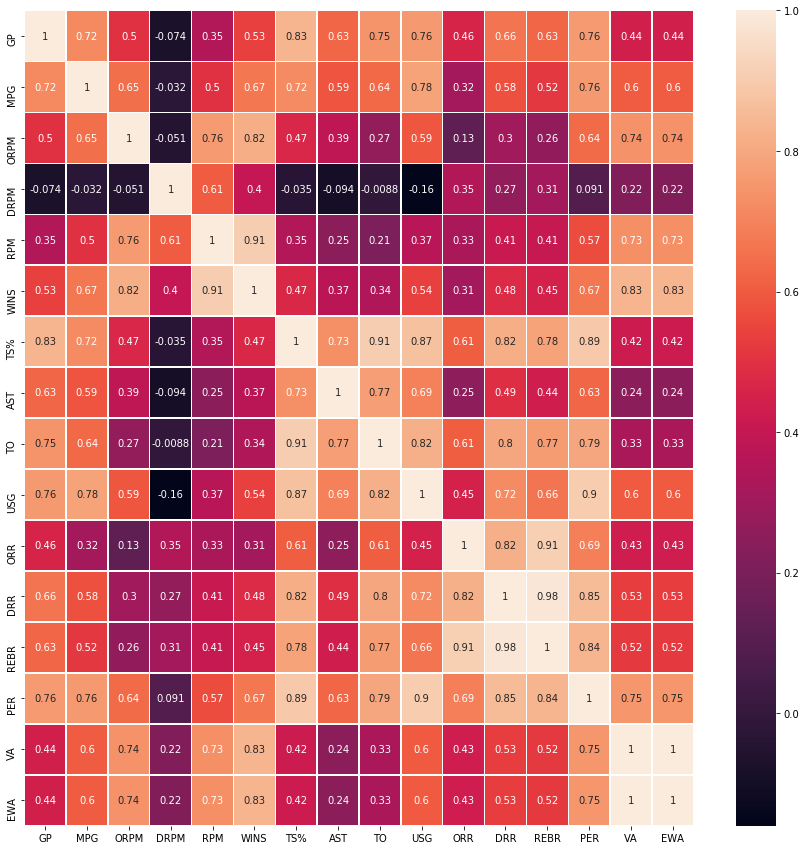

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(metrics_df.corr(),annot=True, linewidths=.5, ax=ax)

We can draw all kinds of conclusions with this data. Here's what we noticed at a quick glance.

1) VA and EWA have a positive 1 correlation, which is expected given they're both similar

2) We want to look for moderate positive or strong positive correlations for VA. Only 5 stats fit this: MPG, RPM, WINS, USG, PER. We ignored ORPM as it is included in RPM. 

There's more insights we can draw from, but these two pieces are relevant to what we want to solve. 

# Multiple Linear Regression Model

In [32]:
#Split for Multiple Linear Regression
X_high_correlation = metrics_df[['MPG','RPM','WINS','USG','PER']]
y = metrics_df[['VA']]

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_high_correlation, y, test_size = 0.2, random_state = 0)


# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

print('Intercept: \n', regressor.intercept_)
print('Coefficients: \n', regressor.coef_)

Intercept: 
 [-38.282555]
Coefficients: 
 [[ -1.5278206 -12.385244   34.49313    -2.3249295   8.19796  ]]


/Users/hdeva/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's compare this using stat OLS models

In [33]:
#Getting Regression results using stat models
import statsmodels.api as sm
X_high_correlation = sm.add_constant(X_high_correlation)
model = sm.OLS(y, X_high_correlation).fit()
predictions = model.predict(X_high_correlation)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     VA   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     344.6
Date:                Fri, 01 Mar 2019   Prob (F-statistic):          2.22e-157
Time:                        12:21:23   Log-Likelihood:                -2615.8
No. Observations:                 493   AIC:                             5244.
Df Residuals:                     487   BIC:                             5269.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.3318      7.281     -5.264      0.000     -52.639     -24.025
MPG           -1.7042      0.441     -3.864      0.000      -2.571      -0.838
RPM          -12.9174      2.801     -4.611      0.000     -18.421      -7.414
WINS          35.5827      2.608     13.643      0.000      30.458      40.707
USG           -2.3572      0.660     -3.570      0.000      -3.655      -1.060
PER            8.4731      0.844     10.034      0.000       6.814      10.132
==============================================================================
Omnibus:                       18.659   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.650
Skew:                           0.184   Prob(JB):                     6.68e-09
Kurtosis:                       4.303   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Predict VA for Players

There are 4 players I chose specifically for testing this model. 

1) Blake Griffin. Detroit Pistons. He was voted as an All - Star, but has PER and VA are lower than his teammate's (Andre Drummond). Drummond is 2nd fiddle to Griffin. Griffin also has a lower RPM than Kevon Looney.

2) Andre Drummond. Detroit Pistons. Want to recalculate his new VA to see if his VA is lower than Griffin's.

3) Kevon Looney. Golden State Warriors. The outlier in RPM. While his VA is appropriate, want to see how it gets readjusted based on his enormously high RPM. 

4) Pascal Siakam. Toronto Raptors. He's been playing at an all star level, but isn't voted as one. He is not recognized in PER or VA. His RPM is higher than Griffin's, which showcases his strong impact to the team. I want to see if he is just another outlier like Looney or a legitimate candidate (watching him in games shows he is the latter). 

In [34]:
Blake_Griffin_MPG = 35.9	
Blake_Griffin_RPM = 	3.09
Blake_Griffin_WINS = 7.90
Blake_Griffin_USG = 30.9
Blake_Griffin_PER = 21.38

Andre_Drummond_MPG = 33.2		
Andre_Drummond_RPM = 1.67
Andre_Drummond_WINS = 5.49
Andre_Drummond_USG = 22.9
Andre_Drummond_PER = 22.76

Pascal_Siakam_MPG = 31.6			
Pascal_Siakam_RPM = 3.85
Pascal_Siakam_WINS = 8.68
Pascal_Siakam_USG = 19.7
Pascal_Siakam_PER = 18.85

Kevon_Looney_MPG = 19.9			
Kevon_Looney_RPM = 3.12
Kevon_Looney_WINS = 4.91
Kevon_Looney_USG = 12.5
Kevon_Looney_PER = 16.61


print ('Predicted Blake Griffin VA: \n', regressor.predict([[Blake_Griffin_MPG, 
                                                             Blake_Griffin_RPM,
                                                             Blake_Griffin_WINS,
                                                             Blake_Griffin_USG,
                                                             Blake_Griffin_PER]]))
    
print ('Predicted Andre Drummond VA: \n', regressor.predict([[Andre_Drummond_MPG, 
                                                             Andre_Drummond_RPM,
                                                             Andre_Drummond_WINS,
                                                             Andre_Drummond_USG,
                                                             Andre_Drummond_PER]]))

print ('Predicted Pascal Siakam VA: \n', regressor.predict([[Pascal_Siakam_MPG, 
                                                             Pascal_Siakam_RPM,
                                                             Pascal_Siakam_WINS,
                                                             Pascal_Siakam_USG,
                                                             Pascal_Siakam_PER]])) 

print ('Predicted Kevon Looney VA: \n', regressor.predict([[Kevon_Looney_MPG, 
                                                             Kevon_Looney_RPM,
                                                             Kevon_Looney_WINS,
                                                             Kevon_Looney_USG,
                                                             Kevon_Looney_PER]]))   

Predicted Blake Griffin VA: 
 [[244.52606792]]
Predicted Andre Drummond VA: 
 [[213.02240833]]
Predicted Pascal Siakam VA: 
 [[273.8859235]]
Predicted Kevon Looney VA: 
 [[169.13961572]]


# Conclusions

This new regression model accurately places Blake Griffin above Drummond and Looney. The biggest surprise is that Pascal Siakam outperformed Blake Griffin. Siakam has more of an impact on the Raptors than previously thought, and it is a shame he wasn't voted to the All Stars this year. 